################################################################################################################
# CLASSIFYING 911 CALLS #
################################################################################################################

## DESCRIPTION :: Emergency (911) Calls: Fire, Traffic, EMS for Montgomery County, PA

- You can get a quick introduction to this Dataset with this kernel: Dataset Walk-through @ https://www.kaggle.com/mchirico/d/mchirico/montcoalert/dataset-walk-through-911

## SOURCE :: KAGGLE 
* https://www.kaggle.com/mchirico/montcoalert

## WHY I'M INTERESTED / MY DOMAIN EXPERTISE

I've worked as an EMT and completed paramedic school in 2012.  Two things surprised me from my paramedic internship:
- we spent a lot of time driving from post to post, filling the space left when another unit went on a call
- we responded to a lot of calls that did not need paramedic-level care (needed basic - not advanced - life support based on clinical criteria)
- my preceptor once remarked that she got most calls for dead on arrival in the morning...when someone woke up next to their dead spouse

## WHAT I'M HOPING TO GAIN FROM THIS
- find hotspots & trends for
- - all calls
- - specific types of calls
- - time
- - level of response requested

## HAVE TO DISCUSS WHAT I'M OPTIMIZING FOR AND WHY BASED ON THE DOMAIN:
- accuracy
- sensitivity
- specificity
- precision
- rocauc // threshold-ambiguous

> # BASIC PACKAGES IMPORTS

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

> # DATA IMPORT

In [8]:
data = pd.read_csv('http://localhost:8888/files/PROJECT%20-%20BBURKART/DATA/911.csv')
data.shape

(120518, 9)

### overview

In [9]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120518 entries, 0 to 120517
Data columns (total 9 columns):
lat          120518 non-null float64
lng          120518 non-null float64
desc         120518 non-null object
zip          104887 non-null float64
title        120518 non-null object
timeStamp    120518 non-null object
twp          120467 non-null object
addr         119910 non-null object
e            120518 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 8.3+ MB


lat              0
lng              0
desc             0
zip          15631
title            0
timeStamp        0
twp             51
addr           608
e                0
dtype: int64

### first look

In [10]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


> # CLEANING

In [11]:
# conventionalize column names
data.columns = [each.replace('-','_').lower() for each in data.columns]
data.columns = [each.replace(' ','_').lower() for each in data.columns]
data = data.rename(columns = {'twp' : 'town', 'addr' : 'address'})

# column 'e' containes '1' for every row, so not helpful --> drop
data = data.drop('e', 1) 


# replace null values with 'unknown'
data['town'].fillna('Unknown', inplace =True)
data['address'].fillna('Unknown', inplace =True)


# split 'title' into 'agency' and 'complaint'
data['agency'] = data['title'].apply(lambda x: x.split(': ')[0])
data['complaint'] = data['title'].apply(lambda x: x.split(': ')[1])


# split 'address' into individual streets
def parse_street(s, which='first'):
    s = str(s)
    if '&' in s:
        if which == 'first':
            return s.split('&')[0]
        else:
            return s.split('&')[1]
    else:
        if which == 'first':
            return s
        else:
            return None
        
data['street1'] = data['address'].apply(lambda x:parse_street(x, which='first'))
data['street2'] = data['address'].apply(lambda x:parse_street(x, which='second'))


# clean up zip 

def clean_zip(x):
    x = str(x)
    if 'nan' in x:
        return x.replace('nan', 'Unknown')
    elif len(x) > 5:
        return x[:5]
    
data['zip'] = data['zip'].apply(lambda x:clean_zip(x))

# zip has 15,631 missing entries; use lat & lng to get zips ()


# add 'lat' and 'lng' to make a single 'latlng'
# data['latlng'] = data['lat'].x.astype(str)+', '+data['lng'].astype(str)


# make true/false columns for contains 'emergency', 'pain / injury', 'vehicle', 'fall', 



# data['emergency'] = data['complaint'].apply(lambda x:)
    
# need a get dummies for agency & complaint categories

    
    
    
data.head()

,lat,lng,desc,zip,title,timestamp,town,address,agency,complaint,street1,street2
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,REINDEER CT,DEAD END
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,DIABETIC EMERGENCY,BRIAR PATH,WHITEMARSH LN
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,Fire,GAS-ODOR/LEAK,HAWS AVE,None
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,EMS,CARDIAC EMERGENCY,AIRY ST,SWEDE ST
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,Unknown,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,DIZZINESS,CHERRYWOOD CT,DEAD END


In [226]:
# # clean traffic complaints to remove ' - '
# def clean_traffic(x):
#     if data.agency == 'Traffic':
#         return x.replace(' - ', '')
#     else: return x
    
data['complaint'] = data['complaint'].replace(' - ', '')

data[data.agency == 'Traffic']['complaint'].value_counts()

VEHICLE ACCIDENT -             27981
DISABLED VEHICLE -              9240
ROAD OBSTRUCTION -              3770
HAZARDOUS ROAD CONDITIONS -     1232
VEHICLE FIRE -                   678
VEHICLE LEAKING FUEL -            91
DEBRIS/FLUIDS ON HIGHWAY -        69
Name: complaint, dtype: int64

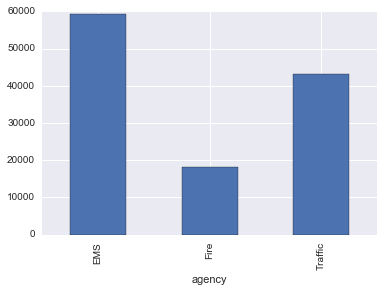

In [231]:
data.groupby(['agency'])['title'].count().plot(kind = 'bar')

In [239]:
ems = data[data.agency == 'EMS']['complaint'].value_counts().head(15)
fire = data[data.agency == 'Fire']['complaint'].value_counts().head(15)
traffic = data[data.agency == 'Traffic']['complaint'].value_counts().head(15)

fig = plt.figure()
ax1.plot(ems)


ValueError: could not convert string to float: 'HEMORRHAGING'

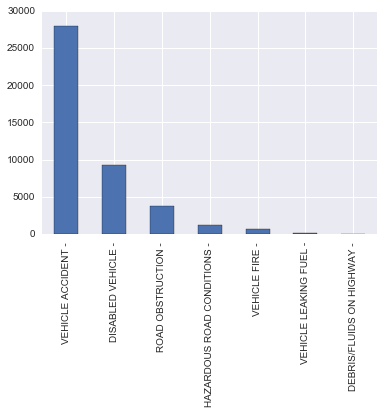

In [171]:
data[data.agency == 'Traffic']['complaint'].value_counts().plot(kind = 'bar')

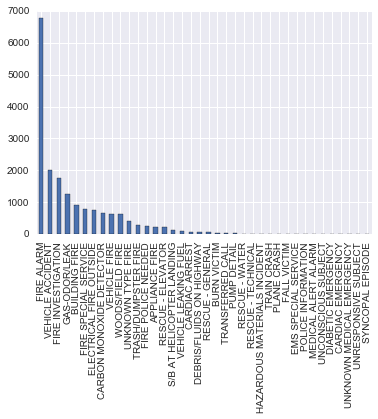

In [217]:
data[data.agency == 'Fire']['complaint'].value_counts().plot(kind = 'bar')

In [216]:
data[data.agency == 'Fire'].groupby(data.complaint).count().plot

,lat,lng,desc,zip,title,timestamp,town,address,agency,complaint,street1,street2,latlng
complaint,,,,,,,,,,,,,
ABDOMINAL PAINS,1745,1745,1745,102,1745,1745,1745,1745,1745,1745,1745,1710,1745
ACTIVE SHOOTER,2,2,2,0,2,2,2,2,2,2,2,2,2
ALLERGIC REACTION,526,526,526,41,526,526,526,526,526,526,526,517,526
ALTERED MENTAL STATUS,1681,1681,1681,107,1681,1681,1681,1681,1681,1681,1681,1631,1681
AMPUTATION,20,20,20,4,20,20,20,20,20,20,20,18,20
ANIMAL BITE,96,96,96,10,96,96,96,96,96,96,96,87,96
APPLIANCE FIRE,14,14,14,0,14,14,14,14,14,14,14,14,14
ARMED SUBJECT,1,1,1,0,1,1,1,1,1,1,1,1,1
ASSAULT VICTIM,827,827,827,72,827,827,827,827,827,827,827,735,827


### complaint categories

- ENVIRONMENTAL
- - contains: 'dehydration', 'allergic', 'animal', 'carbon monoxide', 'drown', 'poison', 

- MENTAL
- - contains: 'syncop', 'seiz', 'overdose', 'unresponsive', 'weakness', 'cva', 'stroke', 'unconscious', 'diabet', 'dizz', 'fever', 'mental', 'poison'

- CARDIAC
- - contains 'cardiac'

- RESPIRATORY
- - contains: 'respiratory', 'chok', 'drown'

- TRAUMA
- - contains: 'fall', 'injury', 'electr', 'fire', 'amputation', 'lacerat', 'bite', 'assault', 'hemmorrhag', 'fracture', 'burn', 'crash' 

- PAIN
- - contains: 'pain'

- POLICE
- - contains: 'suspicious', 'armed', 'warrant', 'bomb', 'shooter', 'stab', 'assault', 'special service', 'warrant', 'crash'

- FIRE
- - contains: 'fire', 'rescue', 'accident', 'special service', 'crash'

- unknown

In [ ]:
environmental = 

In [116]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

def get_location(latlng):
    i = str(latlng)
    if i != 'Unknown':
        return data['zip']
    else:
        location = geolocator.reverse(i)
        return location

data['zip1'] = data['zip'].apply(lambda x:get_location(x))
data['zip1'].head()

KeyboardInterrupt: 

In [90]:
data['location'] = data['combined_lat_long'].apply(get_location)

GeocoderTimedOut: Service timed out

In [ ]:
# get station from description ['desc']

def get_station(desc, )
    station = str(desc)
    if 'station' in desc:
        return desc

In [49]:
data['complaint'] = data.replace(' - ', '')
data['complaint']

0         40.2979
1         40.2581
2         40.1212
3         40.1162
4         40.2515
5         40.2535
6         40.1821
7         40.2173
8          40.289
9         40.1024
10         40.232
11        40.0842
12        40.1741
13         40.063
14        40.0972
15        40.2238
16        40.2433
17        40.3122
18        40.1142
19        40.2093
20        40.1142
21        40.1179
22         40.199
23        40.1433
24        40.1533
25         40.133
26        40.1553
27        40.0289
28        40.0972
29        40.2093
           ...   
120488    39.9991
120489    40.1165
120490    40.2605
120491    40.2368
120492    40.1197
120493    40.0893
120494    40.1433
120495    40.1118
120496     40.109
120497    40.1116
120498    40.2492
120499    40.1593
120500    40.1116
120501    40.1258
120502    40.1258
120503    40.0087
120504    40.0087
120505    40.0728
120506     40.289
120507    40.2394
120508    40.0378
120509     40.025
120510    40.1794
120511    40.1794
120512    

### desc --> cross_street (street1 & street2); town; station; year-month-day @ hour:minute:second;

### but, 
- cross_street == address
- town == town
- timestamp --> contains year-month-day @ hour:minute:second

### so, just need station desc[2] 
> # working on this; 
> - consider a function which looks for 'station' and returns until ';'

In [87]:
data.head()

,lat,lng,desc,zip,title,timestamp,town,address,street1,street2
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,REINDEER CT,DEAD END
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,BRIAR PATH,WHITEMARSH LN
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,HAWS AVE,None
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,AIRY ST,SWEDE ST
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,CHERRYWOOD CT,DEAD END


In [88]:
data.street1.value_counts().sort(ascending = False)

C:\Users\brendanburkart\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


### zip --> 5-digit zip

In [32]:
data['zip'] = data['zip'].round()
data.zip.head(10)

0    19525.0
1    19446.0
2    19401.0
3    19401.0
4        NaN
5    19446.0
6    19044.0
7    19426.0
8    19438.0
9    19462.0
Name: zip, dtype: float64

### title --> agency: complaint

### Split 'title' into 'agency' and 'title'

### Fix Time & Date to expand all and assign day of week

In [18]:
data.timestamp.head()

0    2015-12-10 17:40:00
1    2015-12-10 17:40:00
2    2015-12-10 17:40:00
3    2015-12-10 17:40:01
4    2015-12-10 17:40:01
Name: timestamp, dtype: object

In [24]:
data['timestamp']=pd.to_datetime(data['timestamp'])

In [25]:
data['date'] = data['timestamp'].apply(lambda x: x.split(' ')[0])
data.date.head()

AttributeError: 'Timestamp' object has no attribute 'split'

In [30]:
import datetime
datetime.datetime(data.date).weekday()

from datetime import date
import calendar
data['day_of_week'] = calendar.day_name[data['date'].weekday()]

data['day_of_week'] = data['timestamp'].apply(lambda x: x.weekday())
data.day_of_week.head()

0    3
1    3
2    3
3    3
4    3
Name: day_of_week, dtype: int64

In [102]:
data['year'] = data['date'].apply(lambda x: x.split('-')[0])
data.year.head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: year, dtype: object

In [103]:
data['month'] = data['date'].apply(lambda x: x.split('-')[1])
data.month.head()

0    12
1    12
2    12
3    12
4    12
Name: month, dtype: object

In [104]:
data['day'] = data['date'].apply(lambda x: x.split('-')[2])
data.day.head()

0    10
1    10
2    10
3    10
4    10
Name: day, dtype: object

In [106]:
data['time'] = data['timestamp'].apply(lambda x: x.split(' ')[1])
data.time.head()

0    17:40:00
1    17:40:00
2    17:40:00
3    17:40:01
4    17:40:01
Name: time, dtype: object

In [107]:
data['hour'] = data['time'].apply(lambda x: x.split(':')[0])
data.hour.head()

0    17
1    17
2    17
3    17
4    17
Name: hour, dtype: object

In [108]:
data['minute'] = data['time'].apply(lambda x: x.split(':')[1])
data.minute.head()

0    40
1    40
2    40
3    40
4    40
Name: minute, dtype: object

In [109]:
data['second'] = data['time'].apply(lambda x: x.split(':')[2])
data.second.head()

0    00
1    00
2    00
3    01
4    01
Name: second, dtype: object

In [110]:
data.head()

,lat,lng,desc,zip,title,timestamp,town,address,street1,street2,date,time,year,month,day,hour,minute,second
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,REINDEER CT,DEAD END,2015-12-10,17:40:00,2015,12,10,17,40,00
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,BRIAR PATH,WHITEMARSH LN,2015-12-10,17:40:00,2015,12,10,17,40,00
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,HAWS AVE,None,2015-12-10,17:40:00,2015,12,10,17,40,00
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,AIRY ST,SWEDE ST,2015-12-10,17:40:01,2015,12,10,17,40,01
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,CHERRYWOOD CT,DEAD END,2015-12-10,17:40:01,2015,12,10,17,40,01


In [10]:
data.time = data.timeStamp.str.extract('(..:..:..)', expand = True)
data.time

,0
0,17:40:00
1,17:40:00
2,17:40:00
3,17:40:01
4,17:40:01
5,17:40:01
6,17:40:01
7,17:40:01
8,17:40:01
9,17:40:01


### See about getting Zip from lat & lng; it might be easiest to just replace zip column to make it standard

### Split 'address' by the '&' into street_1 and street_2; if street_2 == null, set as 'none'

# NOTES
- maybe can use lat/lng to determine radiuses & time between calls in that area


## Ideas
- some way to map these once categorized?
- any way to animate it over time?
- are there any trends for the types of calls? ems / fire / types of chief complaint?


### CLASSIFY based on 
- ems / fire, etc
- town name ('twp')
- further split the calls into chief complaints
- time of day, day of week, month, etc


### GOAL :: Recommend geographical & time staffing for each type of emergency (fire, ems, trauma, ALS) 